<a href="https://colab.research.google.com/github/muvision/CNN-v4/blob/main/CNN_model_v4_small_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation

In [ ]:
# Import dependencies
!pip install opendatasets
!pip install pandas
!pip install kaggle
!pip install unrar
!pip install patool
import tensorflow as tf
import opendatasets as od
import pandas as pd
import numpy as np
import cv2 as cv
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import patoolib
from PIL import Image

In [ ]:
# Mount Google Drive if using Google Colab
# from google.colab import drive
# drive.mount('/content/drive/')

In [ ]:
# Initialize paths
data_dir = os.path.join(os.curdir, 'handwrittenmathsymbols', 'less_classes_images')
model_dir = os.path.join(os.curdir, 'models')

custom_model_path = os.path.join(model_dir, 'custom_model2.h5')
resnet_model_path = os.path.join(model_dir, 'resnet_model2.h5')
vgg19_model_path = os.path.join(model_dir, 'vgg19_model2.h5')
mobilenet_model_path = os.path.join(model_dir, 'mobilenet_model2.h5')
ensemble_model_path = os.path.join(model_dir, 'ensemble_model2.h5')

In [ ]:
# Initialize important variables and hyper-parameters
classes = 46 # There are 46 symbol classes
input_shape=(45,45,3)
batch_size = 8
image_size = (45, 45)

## Download and unpack dataset from Kaggle

In [ ]:
# Download the dataset from kaggle
# od.download('https://www.kaggle.com/datasets/xainano/handwrittenmathsymbols', force=True)

In [ ]:
# Unrar the data.rar file we got from Kaggle which contains the data
# rar_path = os.path.join(os.curdir, 'handwrittenmathsymbols', 'data.rar')
# out_path = os.path.join(os.curdir, 'handwrittenmathsymbols')
# patoolib.extract_archive(rar_path)

## Preprocess the colors


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
(45, 45)


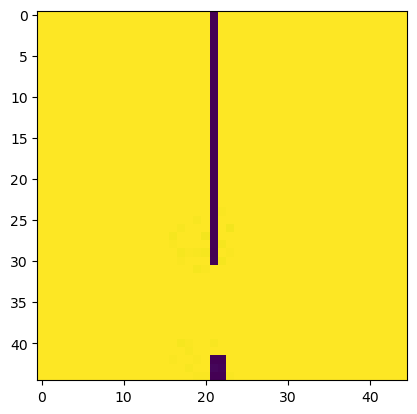

In [ ]:
# Let's see what an individual image in the dataset looks like.
sample_img_path = os.path.join(data_dir, '!', '!_100071.jpg')
sample_img = np.asarray(Image.open(sample_img_path))
imgplot = plt.imshow(sample_img)
print(repr(sample_img))
print(sample_img.shape)

In [ ]:
# Since the images are already gray scale, we don't need to make any changes.

## Preprocess data set

In [ ]:
data_set = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       batch_size = batch_size,
                                                       image_size = image_size)

Found 326536 files belonging to 46 classes.


In [ ]:
# We can check if the images need to be normalized by looking at any image.
img.imread(sample_img_path)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [ ]:
# Normalize images
data_set = data_set.map(lambda x,y: (x/255, y))

In [ ]:
# Allocate training, validation, and test sizes
train_size = int(len(data_set)* .7)
val_size = int(len(data_set)*.2)+1
test_size = int(len(data_set)*.1)+1

In [ ]:
# Split up dataset into train, validation and test
train = data_set.take(train_size)
val = data_set.skip(train_size).take(val_size)
test = data_set.skip(train_size + val_size).take(test_size)

## Create Custom Model using Tensorflow

In [ ]:
custom_model = models.Sequential(name='Custom_Model')

# Convolutional base
custom_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
custom_model.add(layers.MaxPooling2D((2, 2)))
custom_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
custom_model.add(layers.MaxPooling2D((2, 2)))
custom_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Dense layers
custom_model.add(layers.Flatten())
custom_model.add(layers.Dense(64, activation='relu'))
custom_model.add(layers.Dense(classes, activation='softmax'))
custom_model.summary()

# The summary shows that the convolutional base has a (4, 4, 64) output, which
#   is flattened into a (1024) shaped vector, and then sent through two Dense
#   layers
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

custom_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

custom_model_history = custom_model.fit(train, epochs=10,
                         validation_data=val, callbacks=[early_stopping])

custom_model.save(custom_model_path)

Model: "Custom_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 43, 43, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 21, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 19, 19, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 3136)             

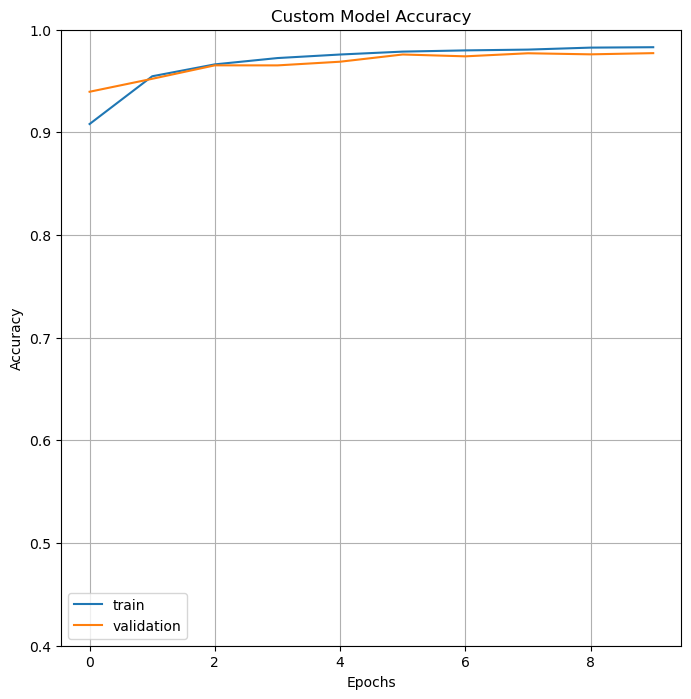

In [ ]:
# Plot history
plt.figure(figsize=(8, 8))
epochs_range= range(10)
plt.plot(epochs_range, custom_model_history.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, custom_model_history.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Custom Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

## Create Model using Resnet-50

In [ ]:
resnet_model = models.Sequential(name='Resnet_Model')

resnet_pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                                                        input_shape=input_shape,
                                                        pooling='max',
                                                        classes=classes,
                                                        weights='imagenet')

# Freeze the layers of the pretrained model
for each_layer in resnet_pretrained_model.layers:
    each_layer.trainable=False

resnet_model.add(resnet_pretrained_model)

In [ ]:
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(64, activation='relu'))
resnet_model.add(layers.Dense(classes, activation='softmax'))

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
resnet_model.compile(optimizer = optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=['accuracy'])
resnet_model.summary()
history = resnet_model.fit(train, validation_data=val, epochs=8, callbacks=[early_stopping])
resnet_model.save(resnet_model_path)

Model: "Resnet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                131136    
                                                                 
 dense_9 (Dense)             (None, 46)                2990      
                                                                 
Total params: 23,721,838
Trainable params: 134,126
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/8
28571/28571 [==============================] - 1202s 42ms/step - loss: 0.6835 - accuracy: 0.8033 - val_loss: 0.4813 - val_accuracy: 0.8586
Epoch 2/8
28571/285

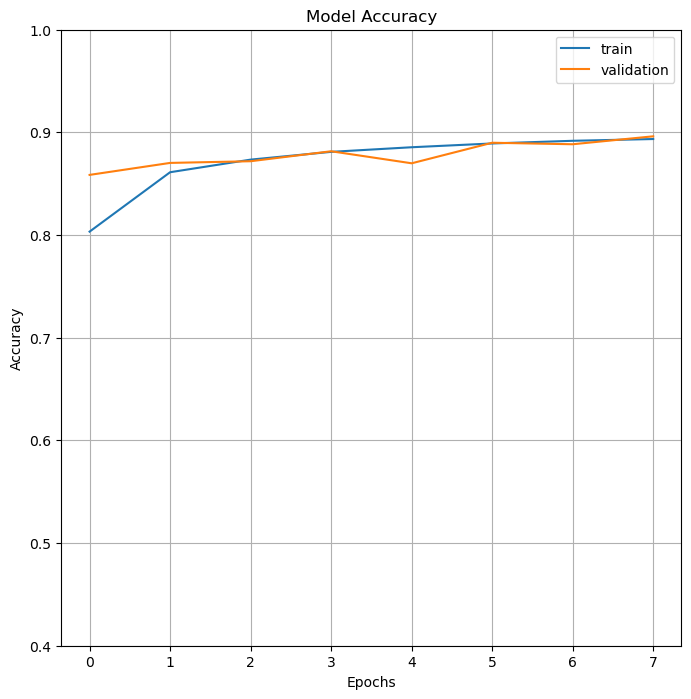

In [ ]:
# Plot history
plt.figure(figsize=(8, 8))
epochs_range= range(8)
plt.plot(epochs_range, history.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Resnet-50 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

## Create Model using VGG19

In [ ]:
from tensorflow.keras.applications import VGG19

In [ ]:
vgg19_model = models.Sequential(name='VGG19_Model')

vgg19_pretrained_model= tf.keras.applications.VGG19(include_top=False,
                                                    input_shape=input_shape,
                                                    pooling='max',
                                                    classes=classes,
                                                    weights='imagenet')

for each_layer in vgg19_pretrained_model.layers:
    each_layer.trainable=False

vgg19_model.add(vgg19_pretrained_model)

In [ ]:
vgg19_model.add(layers.Flatten())
vgg19_model.add(layers.Dense(128, activation='relu'))
vgg19_model.add(layers.Dense(classes, activation='softmax'))

In [ ]:
vgg19_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])

epochs = 8
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
try:
  history = vgg19_model.fit(train, validation_data=val, epochs=epochs, callbacks=[early_stopping])
except Exception as e: print(e)

vgg19_model.save(vgg19_model_path)

Epoch 1/8
28571/28571 [==============================] - 2123s 74ms/step - loss: 0.5366 - accuracy: 0.8428 - val_loss: 0.3778 - val_accuracy: 0.8864
Epoch 2/8
28571/28571 [==============================] - 2187s 77ms/step - loss: 0.3383 - accuracy: 0.8956 - val_loss: 0.3553 - val_accuracy: 0.8927
Epoch 3/8
28571/28571 [==============================] - 2183s 76ms/step - loss: 0.2930 - accuracy: 0.9082 - val_loss: 0.3233 - val_accuracy: 0.9049
Epoch 4/8
28571/28571 [==============================] - 2244s 79ms/step - loss: 0.2661 - accuracy: 0.9160 - val_loss: 0.3024 - val_accuracy: 0.9068
Epoch 5/8
28571/28571 [==============================] - 2373s 83ms/step - loss: 0.2473 - accuracy: 0.9213 - val_loss: 0.3027 - val_accuracy: 0.9070
Epoch 6/8
28571/28571 [==============================] - 2326s 81ms/step - loss: 0.2332 - accuracy: 0.9260 - val_loss: 0.2837 - val_accuracy: 0.9133
Epoch 7/8
28571/28571 [==============================] - 2328s 81ms/step - loss: 0.2218 - accuracy: 0.9293

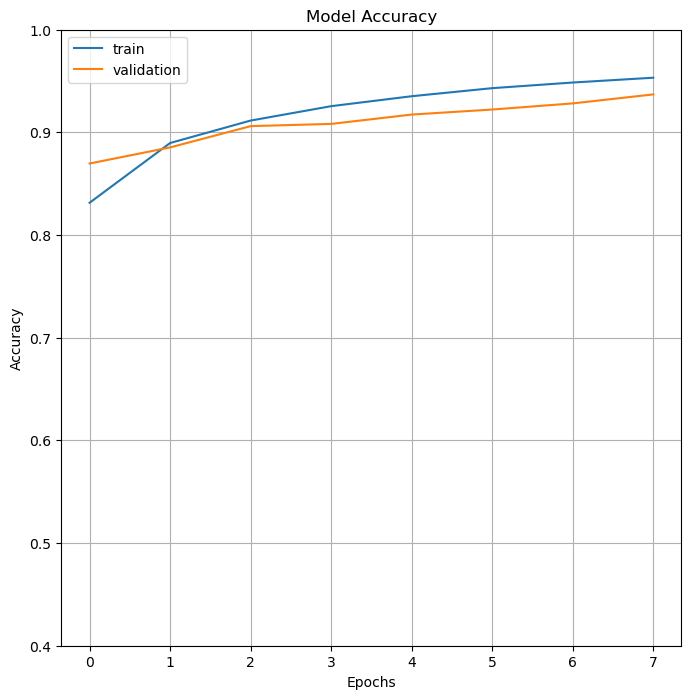

In [ ]:
# Test
plt.figure(figsize=(8, 8))
epochs_range= range(epochs)
plt.plot( epochs_range, history.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('VGG19 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

## Create Model using MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
mobilenet_model = models.Sequential(name='MobileNet_Model')
mobilenet_pretrained_model = tf.keras.applications.MobileNetV2(include_top=False,
                                                               input_shape=input_shape,
                                                               pooling='max',
                                                               classes=classes,
                                                               weights='imagenet')
for each_layer in mobilenet_pretrained_model.layers:
    each_layer.trainable=False

mobilenet_model.add(mobilenet_pretrained_model)

In [ ]:
mobilenet_model.add(layers.Flatten())
mobilenet_model.add(layers.Dense(512, activation='relu'))
mobilenet_model.add(layers.Dense(classes, activation='softmax'))

In [ ]:
mobilenet_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        metrics=['accuracy'])

epochs = 8
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
try:
  history = mobilenet_model.fit(train, validation_data=val, epochs=epochs, callbacks=[early_stopping])
except Exception as e: print(e)
mobilenet_model.save(mobilenet_model_path)

Epoch 1/8
28571/28571 [==============================] - 311s 11ms/step - loss: 0.3773 - accuracy: 0.8889 - val_loss: 0.3674 - val_accuracy: 0.8949
Epoch 2/8
28571/28571 [==============================] - 316s 11ms/step - loss: 0.3015 - accuracy: 0.9109 - val_loss: 0.3312 - val_accuracy: 0.9074
Epoch 3/8
28571/28571 [==============================] - 310s 11ms/step - loss: 0.2568 - accuracy: 0.9246 - val_loss: 0.3216 - val_accuracy: 0.9130
Epoch 4/8
28571/28571 [==============================] - 312s 11ms/step - loss: 0.2250 - accuracy: 0.9342 - val_loss: 0.3551 - val_accuracy: 0.9194
Epoch 5/8
28571/28571 [==============================] - 310s 11ms/step - loss: 0.2072 - accuracy: 0.9412 - val_loss: 0.2849 - val_accuracy: 0.9326
Epoch 6/8
28571/28571 [==============================] - 307s 11ms/step - loss: 0.1854 - accuracy: 0.9475 - val_loss: 0.2667 - val_accuracy: 0.9390
Epoch 7/8
28571/28571 [==============================] - 307s 11ms/step - loss: 0.1707 - accuracy: 0.9522 - val_

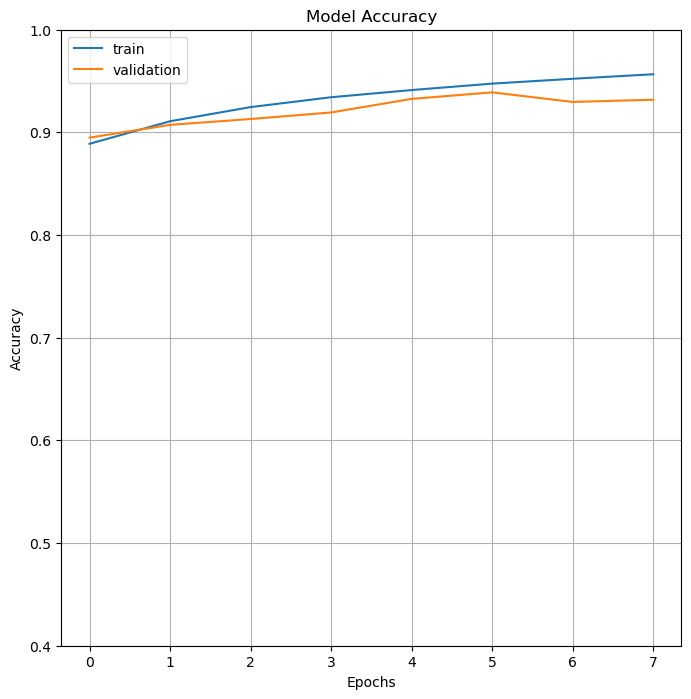

In [ ]:
# Plot history
plt.figure(figsize=(8, 8))
epochs_range= range(epochs)
plt.plot(epochs_range, history.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('MobileNet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

## Ensemble

In [ ]:
# Load trained models from file system
models = [models.load_model(custom_model_path),
          models.load_model(resnet_model_path),
          models.load_model(vgg19_model_path),
          models.load_model(mobilenet_model_path)]

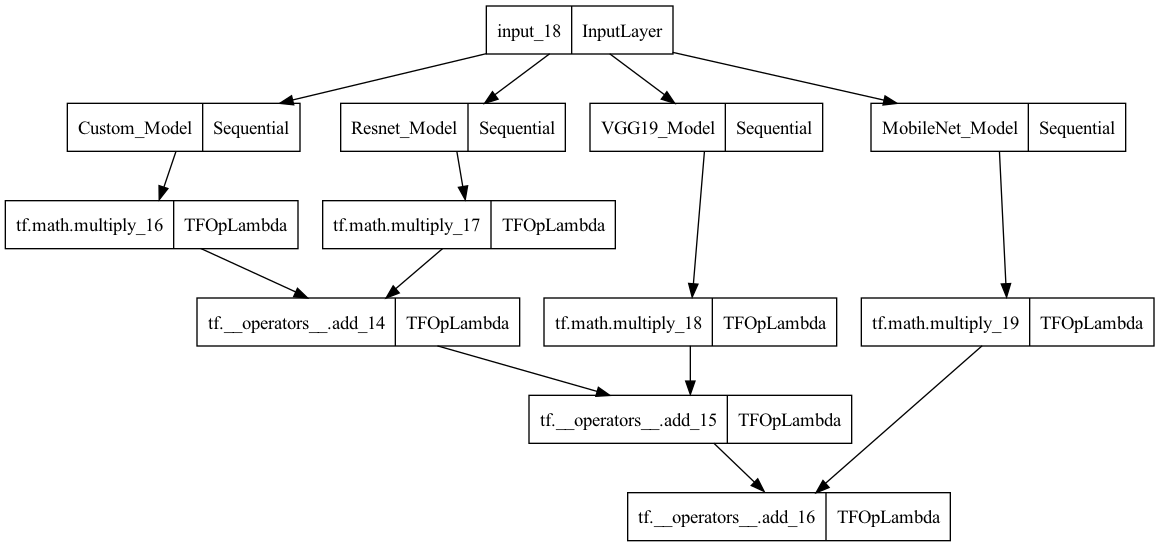

In [ ]:
# Create the weighted average ensemble model
weights = [0.25, 0.25, 0.25, 0.25]
inputs = layers.Input(shape = input_shape)
outputs = [model(inputs) for model in models]
weighted_average = tf.reshape((), (0, classes)) # An empty tensor

for i in range(0, len(models)):
    if i == 0:
        weighted_average = weights[i] * outputs[i]
    else:
        weighted_average = weighted_average + weights[i] * outputs[i]


ensemble_model = tf.keras.Model(inputs = inputs, outputs = weighted_average, name = 'Ensemble_Model')
tf.keras.utils.plot_model(ensemble_model)

In [ ]:
ensemble_model.compile(optimizer = optimizers.Adam(learning_rate=0.001),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['sparse_categorical_accuracy'])
ensemble_model.save(ensemble_model_path)

In [ ]:
ensemble_model.evaluate(test)

4082/4082 [==============================] - 315s 75ms/step - loss: 2.9475 - sparse_categorical_accuracy: 0.9806


[2.9475278854370117, 0.9806160926818848]